# Taxi Environment Q-Learning Analysis

This notebook presents an end-to-end analysis of a Tabular Q-Learning agent applied to the OpenAI Gym `Taxi-v3` environment. It is divided into three key stages:

- **Baseline Evaluation**: Train and evaluate a default Q-Learning agent on the standard Taxi domain.
- **Hyperparameter Tuning**: Optimize learning rate, discount factor, and exploration policy to improve training efficiency and policy quality.
- **Domain Modification**: Explore performance under changes to the environment dynamics or reward structure.

We will visualize the training progress and learned Q-table at each stage to understand the impact of different learning configurations.


## 0.0 Imports and Setup

### 0.1 Import Libraries, Visualizer and Learning Agent

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from taxi_q_visualizer import TaxiQVisualizer
from taxi_q_learner import TaxiQLearner
from taxi_q_learner_optimizer import TaxiQLearnerOptimizer

### 0.2 Helper Function to plot training rewards


In [2]:
def plot_training_rewards(log_path: str, window_size: int = 50):
    """
    Plot total reward per episode from a training log CSV with a smoothed curve.

    Parameters
    ----------
    log_path : str
        Path to CSV file containing 'episode' and 'total_reward' columns.
    window_size : int
        The window size for smoothing the curve.
    """
    df = pd.read_csv(log_path)
    rewards = df['total_reward']
    
    # Apply a moving average for smoothing
    smoothed_rewards = rewards.rolling(window=window_size, min_periods=1).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(df['episode'], rewards, label='Reward', linewidth=0.3)
    plt.plot(df['episode'], smoothed_rewards, label=f'Smoothed (window={window_size})', color='orange', linewidth=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Reward Curve')
    plt.grid(True)
    plt.legend()
    plt.show()


## 1.0 Baseline

**Description**: We train a Tabular Q-Learning agent with the following baseline hyperparameters:

* Learning rate ($\alpha$) = 0.8
* Discount factor ($\gamma$) = 0.95
* Initial exploration ($\epsilon$) = 1.0
* Minimum exploration = 0.01
* Decay factor = 0.999 (after 2000 episodes)
* Decay Threshold = 2000
* Training episodes = 5000
* Max steps per episode = 100

The Q-table has shape (500 states, 6 actions), initialized to zero.


### 1.1 Train the agent on the default (baseline) parameters

In [3]:
base_agent = TaxiQLearner()
base_agent.summary()

   Taxi Q-Learning Model Parameters    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Parameter                   ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Learning Rate (α)           │ 0.800 │
│ Discount Factor (γ)         │ 0.950 │
│ Initial Exploration (ε)     │ 1.000 │
│ Minimum Exploration (min ε) │ 0.010 │
│ Decay Factor                │ 0.999 │
│ Number of Episodes          │  5000 │
│ Max Steps per Episode       │   100 │
└─────────────────────────────┴───────┘

In [10]:
base_agent.train(log_to_csv=True, log_path='baseline/training_log.csv')
base_agent.save_q_table('baseline/q_table.csv')

Training completed after 5000 episodes.
Training log saved to baseline/training_log.csv
Q-table saved to baseline/q_table.csv


### 1.2 Test the agent

In [11]:
# ALERT: Do not use render_mode='human'
base_agent.run(num_episodes=100, verbose=1)

Average Reward over 100 episodes: 7.82


np.float64(7.82)

### 1.3 Plot Baseline Reward Curve

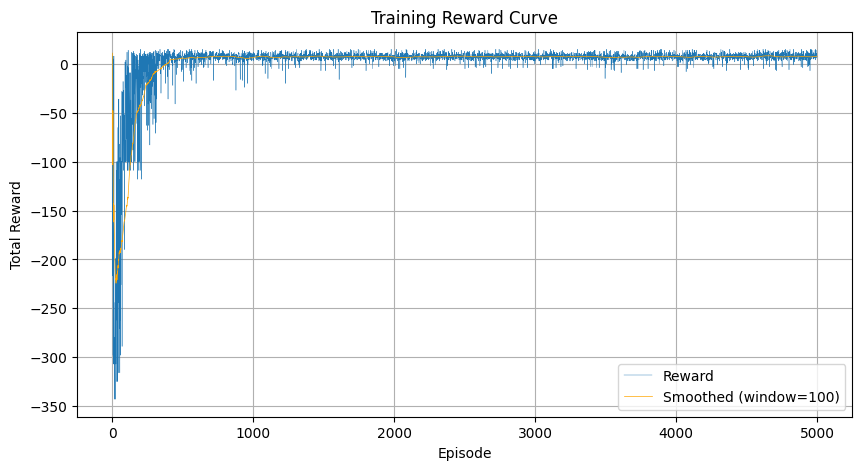

In [12]:
plot_training_rewards('baseline/training_log.csv', window_size=100)

### 1.4 Visualize Baseline Q-Table

In [13]:
visualizer = TaxiQVisualizer('baseline/q_table.csv')

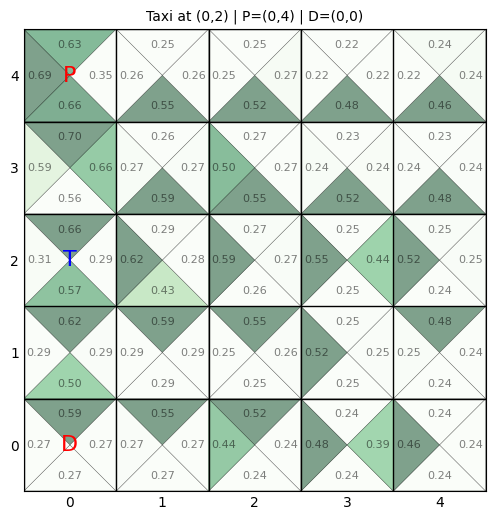

In [15]:
visualizer.run_random_state()


## 1.5 Baseline Performance

* The reward curve above shows how the agent's performance evolves over training.
* We expect an upward trend in total reward, indicating learning.
* The triangle heatmap indicates which actions are preferred in different grid cells under the baseline policy, in a certain state.

*TODO: Add observations and numerical summary of average reward over test episodes here.*

*Next: Part 2 — Hyperparameter Tuning.*


## 2.0 Hyperparameter Tuning

**Description**: We will explore the impact of different hyperparameters on the agent's performance. Our goal will be, to overcome the 7.82 average reward achieved in the baseline.

The following parameters will be tuned:
* Learning rate ($\alpha$) = **0.1, 0.5, 0.8, 0.9, 1.0**
* Discount factor ($\gamma$) = **0.1, 0.5, 0.9, 0.99**
* Initial exploration ($\epsilon$) = **1.0, 0.75, 0.5, 0.25**
* Decay factor = **0.5, 0.9, 0.95, 0.999**
* Decay Threshold = **500, 1000, 2000, 3000** (after 2000 episodes)
* Exploration policy = **linear decay, exponential decay** (For now, we will use the same decay factor as in the baseline)
* Minimum exploration = 0.01
* Training episodes = 5000
* Max steps per episode = 100

The Q-table has shape (500 states, 6 actions), initialized to zero (like in the baseline).


## 2.1 Define hyperparameter grid

In [16]:
learning_rates = [0.1, 0.5, 0.8, 0.9, 1.0] # alpha
discount_factors = [0.1, 0.5, 0.9, 0.99] # gamma
initial_explorations = [1.0, 0.75, 0.5, 0.25] # epsilon
decay_factors = [0.5, 0.9, 0.95, 0.999] 
decay_thresholds = [500, 1000, 2000, 3000]

## 2.2 Train the agent on the hyperparameter grid

In [ ]:
optimizer = TaxiQLearnerOptimizer(learning_rates=learning_rates,
                                  discount_factors=discount_factors,
                                  initial_explorations=initial_explorations,
                                  decay_factors=decay_factors,
                                  decay_thresholds=decay_thresholds)

In [ ]:
# Hyperparameter tuning
for alpha in learning_rates:
    for gamma in discount_factors:
        for epsilon in initial_explorations:
            for decay in decay_factors:
                for threshold in decay_thresholds:
                    file_name = f'hyperparameter_tuning/training_logs/learning_rate_{alpha}_discount_factor_{gamma}_initial_exploration_{epsilon}_decay_factor_{decay}_decay_threshold_{threshold}.csv'
                    q_table_name = f'hyperparameter_tuning/q_tables/learning_rate_{alpha}_discount_factor_{gamma}_initial_exploration_{epsilon}_decay_factor_{decay}_decay_threshold_{threshold}.csv'
                    
                    agent = TaxiQLearner(alpha=alpha, gamma=gamma, epsilon=epsilon, decay_factor=decay, decay_threshold=threshold)
                    agent.train(file_name, verbose=False)
                    agent.save_q_table(q_table_name, verbose=False)

                    average_reward = agent.run(num_episodes=100, verbose=0)

                    print(f"Learning Rate: {alpha}, Discount Factor: {gamma}, Initial Exploration: {epsilon}, Decay Factor: {decay}, Decay Threshold: {threshold}, Average Reward: {average_reward}")